<a href="https://colab.research.google.com/github/Karishma-Kuria/DL-AgeGender-Prediction-Project/blob/main/DL_DriversProject__AgeGenderClassifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Llearning - CMPE258 Section 49**

## **Team Name - DL-Drivers**

## **Team Members: Akanksha Rawat, Karishma Kuria, Nisha Mohan**

# Age & Gender Classifier using CNNs-

**Dataset : UTKFace**

About the dataset: UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.

In this notebook, we have used the `aligned and cropped` faces available to train the models. 

### **Note : so for testing - any face input  must be cropped and aligned vertically to large extent.**

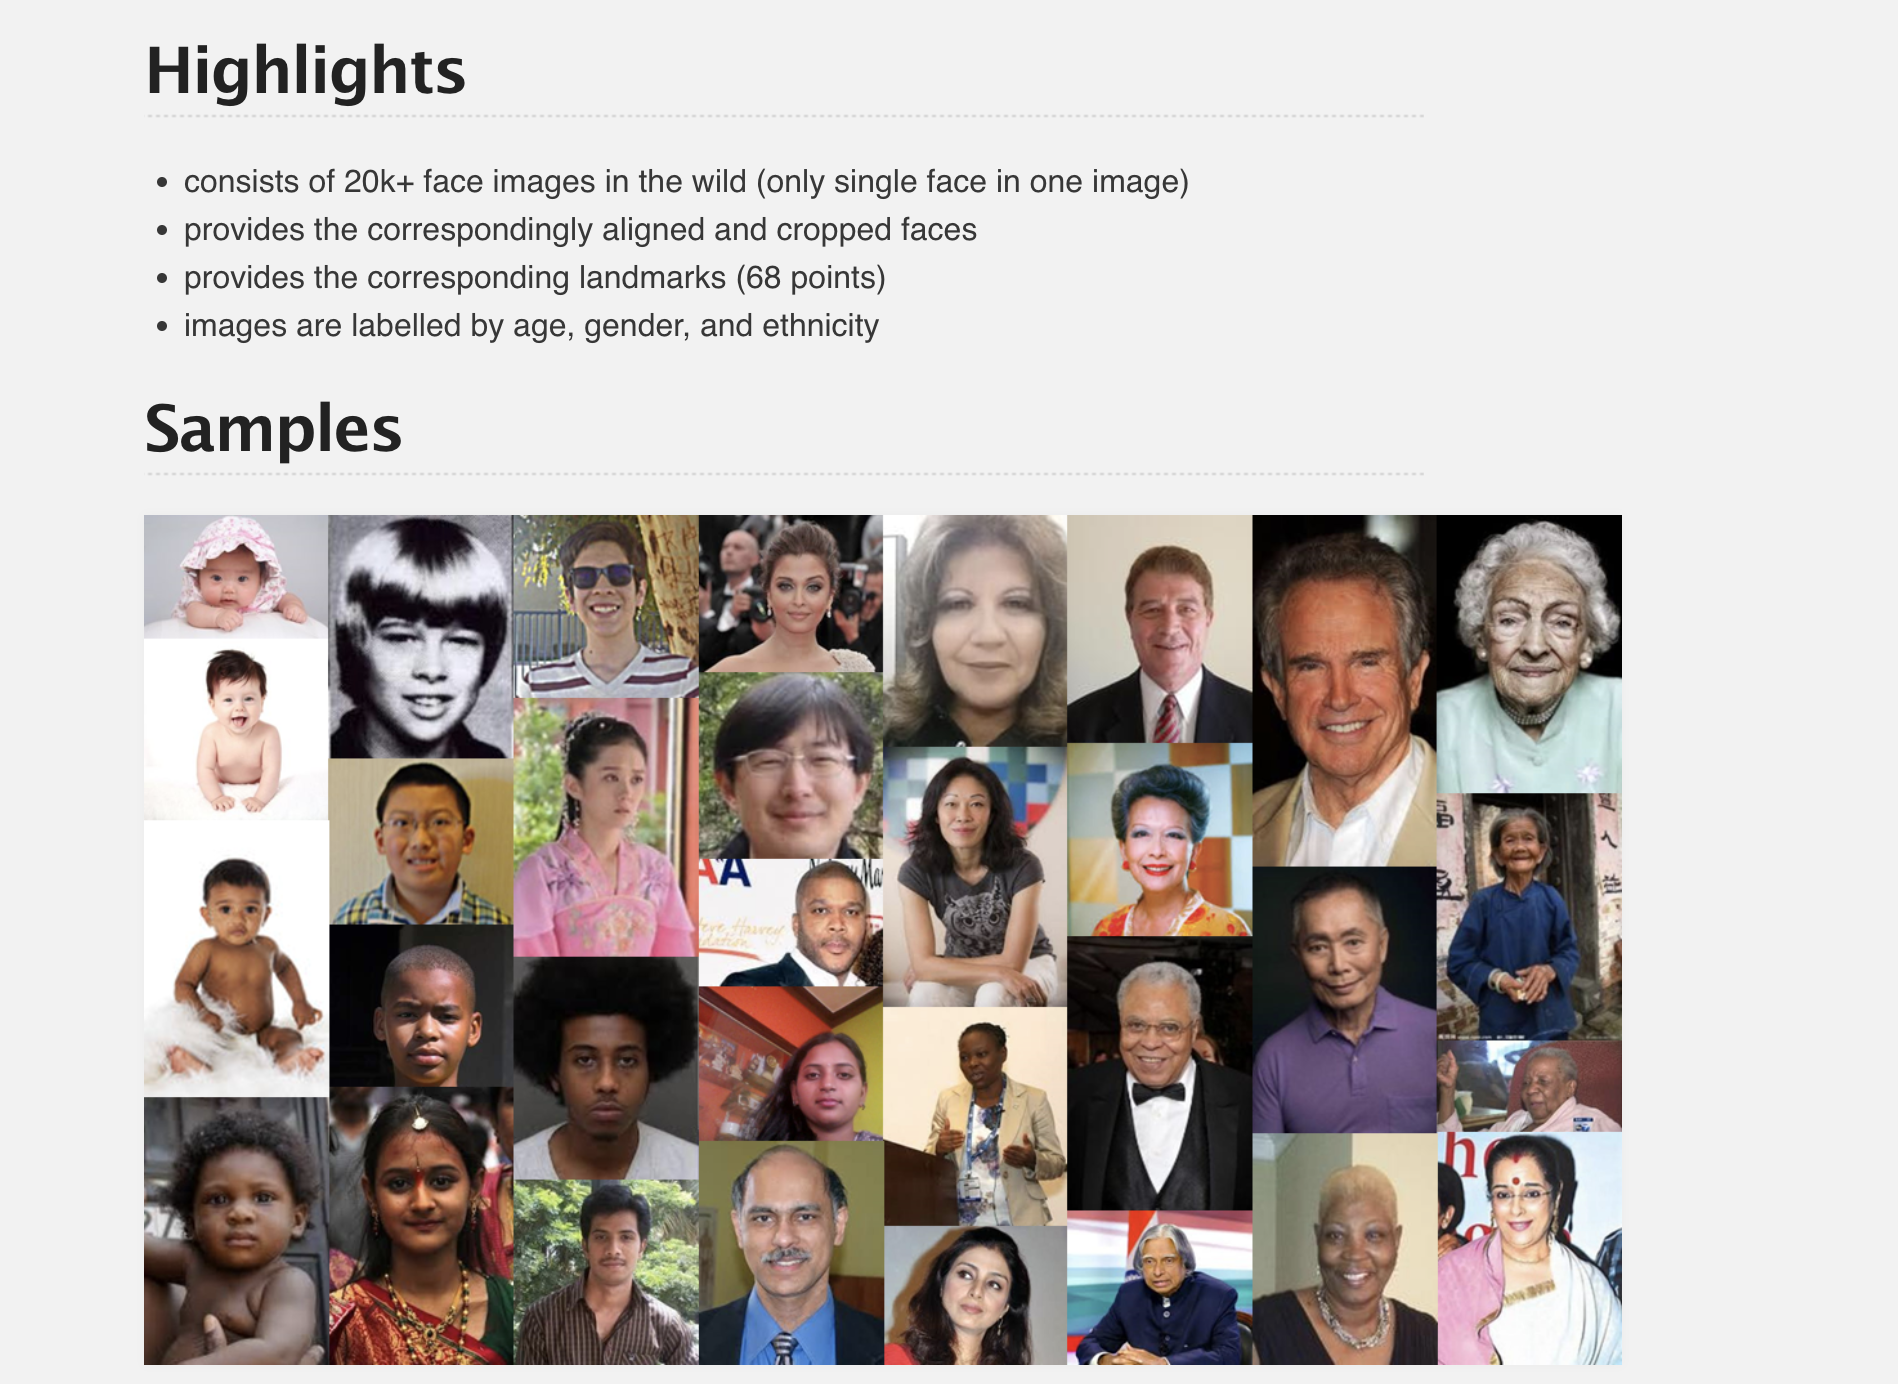

In [ ]:
# Mounting the drive so that dataset can be loaded

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **installing MLflow for model artifacts, metrics and params tracking as part of MLops.**

In [ ]:
!pip install mlflow --quiet

In [ ]:
import mlflow

In [ ]:
print(mlflow.__version__)

1.26.0


In [ ]:
# Create an experiment name, which must be unique and case sensitive
experiment_id = mlflow.create_experiment("Age and gender detection Experiments_4")
experiment = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Name: Age and gender detection Experiments_4
Experiment_id: 2
Artifact Location: file:///content/mlruns/2
Tags: {}
Lifecycle_stage: active


In [ ]:
with mlflow.start_run(run_name="MLflow age and Gender Prediction"):
  mlflow.log_metric("m1", 2.0)
get_ipython().system_raw("mlflow ui --port 5000 &")


In [ ]:
# mlflow.end_run()

In [ ]:
!pip install pyngrok --quiet
from pyngrok import ngrok
from getpass import getpass
# Terminate open tunnels if any exist
ngrok.kill()


In [ ]:
# Enter your auth token when the code is running
ngrok.set_auth_token("29X3gXr4I8paaNKoCBUVwkmq9q8_7jNumvQSv99sdS1EHTLtH")
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)


MLflow Tracking UI: https://67ca-34-141-141-94.ngrok.io


In [ ]:
import mlflow.keras

In [ ]:
mlflow.tensorflow.autolog()

In [ ]:
# Essential libraries
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
dataset_folder_name = '/content/drive/MyDrive/Age_Geneder_UTKDataSet/UTKFace'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [ ]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    
   
    df = df.dropna()
    
    return df

In [ ]:
df = parse_dataset(dataset_folder_name)
df.head()

# Now we have a pandas dataframe with us. This can be dealt with quite easily. Like, we simply now need 
# to OHE gender, race and feed it into model. Using Pandas dataframe also allows me to manipulate and 
# visualize data by plotting graphs.

,age,gender,race,file
0,23.0,female,indian,/content/drive/MyDrive/Age_Geneder_UTKDataSet/...
1,23.0,female,indian,/content/drive/MyDrive/Age_Geneder_UTKDataSet/...
2,23.0,female,indian,/content/drive/MyDrive/Age_Geneder_UTKDataSet/...
3,23.0,female,indian,/content/drive/MyDrive/Age_Geneder_UTKDataSet/...
4,24.0,male,white,/content/drive/MyDrive/Age_Geneder_UTKDataSet/...


### Data analysis & visualization (EDA)

After some data preprocessing, let's analyze the data using graphs to get a  better understanding about its distribution





In [ ]:
df.info()       # No NAN values. Clean dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8600 entries, 0 to 8600
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     8600 non-null   float64
 1   gender  8600 non-null   object 
 2   race    8600 non-null   object 
 3   file    8600 non-null   object 
dtypes: float64(1), object(3)
memory usage: 335.9+ KB


In [ ]:
df.describe()

# Lower percentile - 25, median - 50 & upper percentile - 75 (for numerical data)

,age
count,8600.000000
mean,33.331512
std,19.715395
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


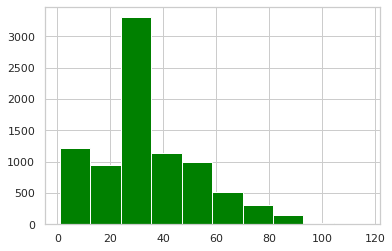

In [ ]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')
plt.show()

# Majority population lies between 20-30 age group. Clearly, the dataset is not very well balanced. So training will 
# not be easy & accurate. We don't want to be biased. Try using class weights ?

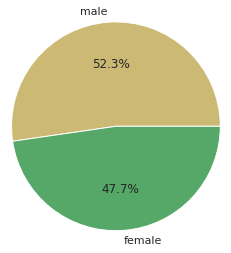

In [ ]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

# Uniform distribution to a large extent. Although, males slightly exceed females in numbers.No need to change gender in data. 
# Pretty well balanced ! Lets also visualize this on a bar graph (to get better understanding of numbers)

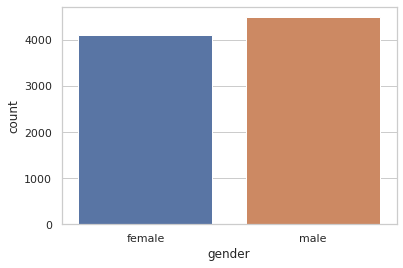

In [ ]:
sns.countplot(x='gender', data=df);

# Males ~ Just over 12k
# Females ~ Just over 11k

In [ ]:
df.groupby(['gender']).mean()             # Mean age by gender

,age
gender,
female,30.750670
male,35.686235


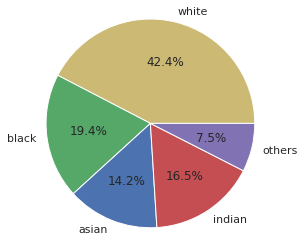

In [ ]:
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

gender = [x,y,z,a,b]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

In [ ]:
df.groupby(['race']).mean()               # Mean age by race

,age
race,
asian,25.852003
black,34.074385
indian,31.317606
others,22.846512
white,38.141289


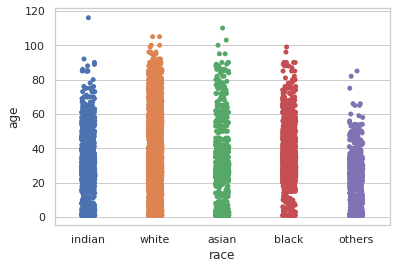

In [ ]:
sns.set(style ="whitegrid") 
_ = sns.stripplot(x='race',y='age',data=df)

# Not very useful :( , we only understand that not many elderly ppl (above 60) in others category are present 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


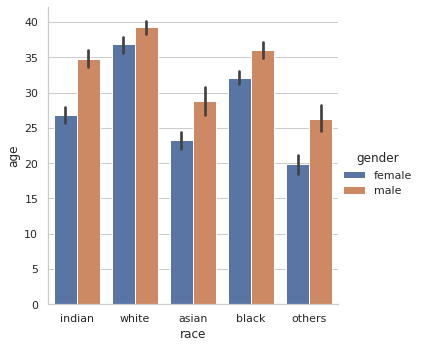

In [ ]:
sns.factorplot('race', 'age', 'gender', data=df,kind='bar');

# Gives the mean age of both genders of all races

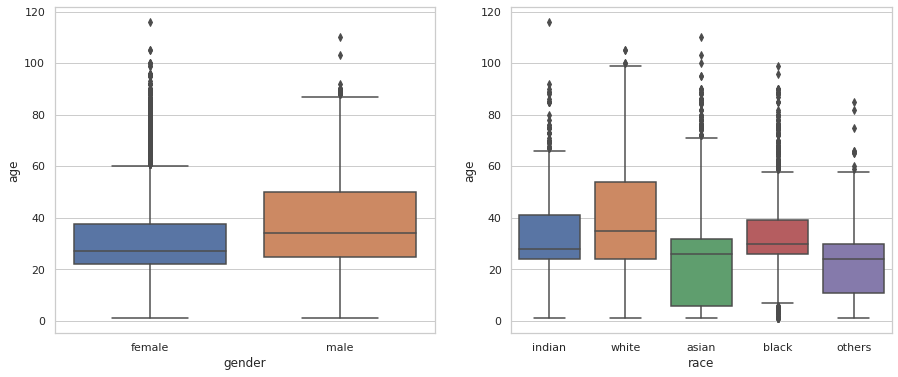

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

# We see that most of males are between 25 and 55, whereas most of the females are between 20 and 35
# Even while grouping by race, we find good amount of variations in different races

In [ ]:
df['age'] = df['age']//25

''' This basically makes 5 divisions in age-groups - 
1. 0-24
2. 25-49
3. 50-74
4. 75-99
5. 100-124 '''

' This basically makes 5 divisions in age-groups - \n1. 0-24\n2. 25-49\n3. 50-74\n4. 75-99\n5. 100-124 '

In [ ]:
x = (df.age==0).sum()
y = (df.age==1).sum()
z = (df.age==2).sum()
a = (df.age==3).sum()
b = (df.age==4).sum()
c = (df.age==5).sum()

print(x,' ',y,' ',z,' ',a,' ',b, ' ',c)


2463   4306   1478   345   8   0


In [ ]:
df.head()

,age,gender,race,file
0,0.0,female,indian,/content/drive/MyDrive/Age_Geneder_UTKDataSet/...
1,0.0,female,indian,/content/drive/MyDrive/Age_Geneder_UTKDataSet/...
2,0.0,female,indian,/content/drive/MyDrive/Age_Geneder_UTKDataSet/...
3,0.0,female,indian,/content/drive/MyDrive/Age_Geneder_UTKDataSet/...
4,0.0,male,white,/content/drive/MyDrive/Age_Geneder_UTKDataSet/...


## Data Generator
In order to input our data to our Keras multi-output model, we have a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model with both the images and their labels (instead of just loading all the dataset into the memory at once, which might lead to an out of memory error).

In [ ]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
p = np.random.permutation(len(df))

train_up_to = int(len(df) * TRAIN_TEST_SPLIT)      
train_idx = p[:train_up_to]
val_idx = p[train_up_to:]

# converts alias to id
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])

# Now we got train_idx, valid_idx, test_idx
            
def preprocess_image(img_path):   # Used to perform some minor preprocessing on the image before inputting into the network.
    
    im = Image.open(img_path)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0
    
    return im
        
def generate_images(image_idx, is_training, batch_size=16):  # Used to generate a batch with images when training/validating our model.
    
    # arrays to store our batched data
    images, ages, races, genders = [], [], [], []

    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            
            age = person['age']
            race = person['race_id']
            gender = person['gender_id']
            file = person['file']
            
            im = preprocess_image(file)
            
            races.append(to_categorical(race, len(dataset_dict['race_id'])))
            genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
            ages.append(to_categorical(age,5))
            images.append(im)
            
            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []
                
        if not is_training:
            break
            

## Model Architecture

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2

import tensorflow as tf

def make_default_hidden_layers(inputs):

    x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

def build_gender_branch(inputs):
  
    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
  
    x = Dense(2)(x)
    x = Activation("softmax", name="gender_output")(x)

    return x

def build_age_branch(inputs):   

    x = make_default_hidden_layers(inputs)
    
    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.03))(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(5)(x)
    x = Activation("softmax", name="age_output")(x)  

    return x


def assemble_model(width, height):
  
    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    age_branch = build_age_branch(inputs)
    gender_branch = build_gender_branch(inputs)

    model = Model(inputs=inputs, outputs = [age_branch, gender_branch], name="DL_Drivers_AgeGender")

    return model
    
model = assemble_model(198, 198)

Filter size tends to decrease with depth of the model (initial layers have larger receptive fields).

In [ ]:
model.summary()

Model: "DL_Drivers_AgeGender"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d_14 (Separable  (None, 198, 198, 32  155        ['input_2[0][0]']                
 Conv2D)                        )                                                                 
                                                                                                  
 activation_19 (Activation)     (None, 198, 198, 32  0           ['separable_conv2d_14[0][0]']    
                                )                                              

**LearningRateSchedular Callback** - The LearningRateScheduler callback allows us to define a function to call that takes the epoch number as an argument and returns the learning rate to use in optimizer. When used, the learning rate specified by optimizer is ignored.

In [ ]:
# A callback is a set of functions to be applied at given stages of the training procedure.

import math

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler


# LRS in Keras reduces the learning rate by a certain factor after certain no of epochs

def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.5
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)                                     # 0.0 here signifies this is not to be used
lrate = LearningRateScheduler(step_decay)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'categorical_crossentropy', 
                  'gender_output': 'categorical_crossentropy'},
              metrics={
                  'age_output': 'accuracy', 
                  'gender_output': 'accuracy'})


callbacks_list = [lrate]

# It is this callback that allows a function to invoke during program execution.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## **Handling imbalance class in Keras using param called `class_weight`**

Class weights, ensure that the unevenness in data distribution is sorted out.
Basically, **classes with less numbers are given more weight**, so that model doesn't get biased towards the more prevalent classes.

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,classes=np.array([0,1,2,3,4]) ,y=np.array(df['age']))


class_weight1 = {'age_output': class_weight}

## **Since, train_idx is too large to fit inside RAM at once, we generate batches of size 32/64 from it (called train_gen))**

In [ ]:
train_gen = generate_images(train_idx, is_training=True, batch_size=32)


valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=22  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



2022/05/23 06:04:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '233363fba1094a4dbdec793d3018de47', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/22
215/215 [==============================] - 52s 221ms/step - loss: 2.6979 - age_output_loss: 1.2333 - gender_output_loss: 0.6526 - age_output_accuracy: 0.4766 - gender_output_accuracy: 0.6398 - val_loss: 2.1526 - val_age_output_loss: 1.1864 - val_gender_output_loss: 0.7589 - val_age_output_accuracy: 0.4800 - val_gender_output_accuracy: 0.5301 - lr: 0.0080
Epoch 2/22
215/215 [==============================] - 44s 203ms/step - loss: 1.8039 - age_output_loss: 1.0977 - gender_output_loss: 0.5205 - age_output_accuracy: 0.5174 - gender_output_accuracy: 0.7506 - val_loss: 2.7974 - val_age_output_loss: 1.8846 - val_gender_output_loss: 0.7159 - val_age_output_accuracy: 0.2353 - val_gender_output_accuracy: 0.6969 - lr: 0.0080
Epoch 3/22
215/215 [==============================] - 44s 204ms/step - loss: 1.6258 - age_output_loss: 1.0172 - gender_output_loss: 0.4157 - age_output_accuracy: 0.5555 - gender_output_accuracy: 0.8132 - val_loss: 2.5665 - val_age_output_loss: 1.8129 - val_gender_

2022/05/23 06:20:52 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/23 06:21:00 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/23 06:21:00 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.7+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLf

## **Experimenting with learning rate parameter**

In [ ]:
import math
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def step_decay(epoch):
	initial_lrate = 0.002
	drop = 0.5
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)
lrate = LearningRateScheduler(step_decay)

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)
callbacks_list = [lrate]

history = model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=22  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022/05/23 06:21:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6585ee28ec0c44ba95a66361f9068835', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/22
215/215 [==============================] - 44s 203ms/step - loss: 0.6356 - age_output_loss: 0.4541 - gender_output_loss: 0.1078 - age_output_accuracy: 0.8246 - gender_output_accuracy: 0.9602 - val_loss: 1.2118 - val_age_output_loss: 0.7097 - val_gender_output_loss: 0.4232 - val_age_output_accuracy: 0.7205 - val_gender_output_accuracy: 0.8721 - lr: 0.0020
Epoch 2/22
215/215 [==============================] - 44s 204ms/step - loss: 0.6076 - age_output_loss: 0.4421 - gender_output_loss: 0.0905 - age_output_accuracy: 0.8246 - gender_output_accuracy: 0.9686 - val_loss: 1.2113 - val_age_output_loss: 0.7424 - val_gender_output_loss: 0.3905 - val_age_output_accuracy: 0.7093 - val_gender_output_accuracy: 0.8774 - lr: 0.0020
Epoch 3/22
215/215 [==============================] - 44s 204ms/step - loss: 0.6187 - age_output_loss: 0.4439 - gender_output_loss: 0.0977 - age_output_accuracy: 0.8218 - gender_output_accuracy: 0.9618 - val_loss: 1.3823 - val_age_output_loss: 0.8592 - val_gender_

2022/05/23 06:37:17 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/23 06:37:25 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/23 06:37:25 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.7+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLf

We see that the model has started overfitting. Validation loss for both age and gender is increasing, which a clear sign of overfitting. Hence, stop the training, else the model might lose its generalization ability.
we tried training further, and the accuracy was not able to increase. Hence, we conclude that the model has achieved saturation.

# **saving the model**

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/DL_AgeGen_best')         # Saving the above run model. It has performed best till date.

model.save(f'/content/drive/My Drive/Colab Notebooks/DL_AgeGen_best.h5')  # Converting to .h5 file for deployment


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/DL_AgeGen_best/assets


In [ ]:
from keras.models import load_model
new_model = load_model('/content/drive/My Drive/Colab Notebooks/DL_AgeGen_best')

In [ ]:
    # Log the sklearn model and register as version 1
mlflow.keras.log_model(model, "final_model")

INFO:tensorflow:Assets written to: /tmp/tmprklkz41p/model/data/model/assets


2022/05/23 06:37:49 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/23 06:37:57 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/23 06:37:57 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.7+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLf

ModelInfo(artifact_path='final_model', flavors={'keras': {'keras_module': 'tensorflow.keras', 'keras_version': '2.8.0', 'save_format': 'tf', 'data': 'data', 'code': None}, 'python_function': {'loader_module': 'mlflow.keras', 'python_version': '3.7.13', 'data': 'data', 'env': 'conda.yaml'}}, model_uri='runs:/fac21c23cd5241dead2c38ee3dd969ac/final_model', model_uuid='69d7c9c9421b44abb1ebeadbd893701a', run_id='fac21c23cd5241dead2c38ee3dd969ac', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-05-23 06:37:40.096435', mlflow_version='1.26.0')

# **Final prediction**

<PIL.Image.Image image mode=RGB size=198x198 at 0x7FCBC1B52190>


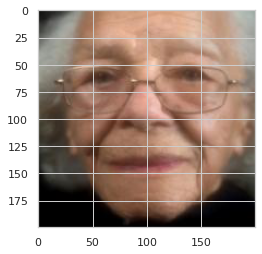

age pred array [1.8130479e-04 8.7110648e-06 1.8198864e-01 8.0722052e-01 1.0600780e-02]
75-99 yrs old
Female


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(198, 198))
  print(test_img)
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255

  return test_img

picture = "/content/drive/MyDrive/Age_Geneder_UTKDataSet/UTKFace/100_1_0_20170112215032192.jpg.chip.jpg"                                     
age_pred, gender_pred = new_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()
max=-1
count=0
print('age pred array', age_pred[0])
for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1

if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')
